In [1]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA
input_current2 = np.stack((input_current0, input_current1))

In [4]:
Ntraces, Nsteps = np.shape(input_current2)

In [5]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [6]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [7]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [8]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

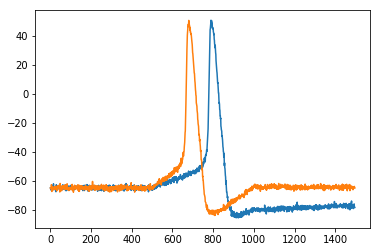

In [9]:
plot(out_trace0)
plot(out_trace1);

### Generate Proper Input Format for the Problem

In [10]:
inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_trace = np.concatenate(([out_trace0], [out_trace1]))

In [11]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
out_trace

array([[-65.00039448, -65.56138935, -66.44217023, ..., -78.62693681,
        -78.38759052, -78.46515865],
       [-65.10295229, -65.1618136 , -65.23360621, ..., -64.03149146,
        -65.13461238, -65.17557454]])

In [13]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

In [14]:
n_opt = NevergradOptimizer()

In [15]:
res, error, ot, te = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                                   n_rounds=2, n_samples=6, optimizer=n_opt,)


INFO       No numerical integration method specified for group 'neurongroup', using method 'exponential_euler' (took 0.18s, trying other methods took 0.11s). [brian2.stateupdaters.base.method_choice]


In [16]:
te

[array([[0.        , 0.00419124, 0.00842162, ..., 0.31207492, 0.31220789,
         0.3123356 ],
        [0.        , 0.00420453, 0.00838309, ..., 0.35100613, 0.35100641,
         0.35100674],
        [0.        , 0.0042144 , 0.00849126, ..., 1.93269317, 1.93269564,
         1.93269885],
        ...,
        [0.        , 0.00417553, 0.0082967 , ..., 0.78356356, 0.78356382,
         0.78356417],
        [0.        , 0.00417923, 0.00838562, ..., 0.33100017, 0.33115901,
         0.33131201],
        [0.        , 0.00419251, 0.00834722, ..., 0.27042945, 0.27042982,
         0.27043006]]),
 array([[0.        , 0.00417132, 0.00836191, ..., 0.60672907, 0.60689654,
         0.607058  ],
        [0.        , 0.00418457, 0.0083236 , ..., 0.25259751, 0.25259799,
         0.25259816],
        [0.        , 0.00417843, 0.00838321, ..., 0.77567518, 0.77584334,
         0.77600546],
        ...,
        [0.        , 0.00418988, 0.00833943, ..., 0.45073294, 0.45073316,
         0.45073356],
        [0. 

In [18]:
xx = ot[0]
xx

array([[ 0.00000000e+00, -2.60592758e-04, -5.20011099e-04, ...,
        -6.71041771e-02, -6.70954751e-02, -6.70868064e-02],
       [ 0.00000000e+00, -2.60592758e-04, -5.20011099e-04, ...,
        -6.45577538e-02, -6.45582442e-02, -6.45587328e-02],
       [ 0.00000000e+00, -8.19904882e-05, -1.63663527e-04, ...,
        -8.02179029e-02, -8.01987071e-02, -8.01795355e-02],
       ...,
       [ 0.00000000e+00, -4.84623139e-04, -9.65436924e-04, ...,
        -6.45443957e-02, -6.45459859e-02, -6.45475654e-02],
       [ 0.00000000e+00, -3.53394678e-04, -7.04750126e-04, ...,
        -6.60300296e-02, -6.60240184e-02, -6.60180381e-02],
       [ 0.00000000e+00, -3.53394678e-04, -7.04750126e-04, ...,
        -6.46364469e-02, -6.46374286e-02, -6.46384053e-02]])

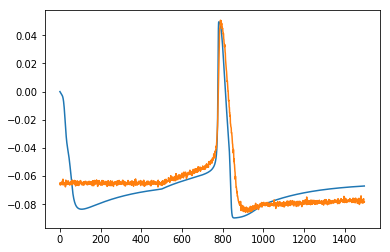

In [95]:
y = out_trace[0] * 10e-4

plt.plot(xx[0]);
plt.plot(y);

In [111]:
from sklearn.metrics import mean_squared_error

rms_list, mse_list = [], []
for row in xx:
    mse = mean_squared_error(y.transpose(), row.transpose())
#     print(mse/len(row))
    print(y)
    print(row)
    print(y-row)
    mse2 = np.sum(np.square(y - row))
    rms = np.sqrt(mse)
    rms_list.append(rms)
    mse_list.append(mse2)
        
#     print(mse, rms)
    

[-0.06500039 -0.06556139 -0.06644217 ... -0.07862694 -0.07838759
 -0.07846516]
[ 0.         -0.00026059 -0.00052001 ... -0.06710418 -0.06709548
 -0.06708681]
[-0.06500039 -0.0653008  -0.06592216 ... -0.01152276 -0.01129212
 -0.01137835]
[-0.06500039 -0.06556139 -0.06644217 ... -0.07862694 -0.07838759
 -0.07846516]
[ 0.         -0.00026059 -0.00052001 ... -0.06455775 -0.06455824
 -0.06455873]
[-0.06500039 -0.0653008  -0.06592216 ... -0.01406918 -0.01382935
 -0.01390643]
[-0.06500039 -0.06556139 -0.06644217 ... -0.07862694 -0.07838759
 -0.07846516]
[ 0.00000000e+00 -8.19904882e-05 -1.63663527e-04 ... -8.02179029e-02
 -8.01987071e-02 -8.01795355e-02]
[-0.06500039 -0.0654794  -0.06627851 ...  0.00159097  0.00181112
  0.00171438]
[-0.06500039 -0.06556139 -0.06644217 ... -0.07862694 -0.07838759
 -0.07846516]
[ 0.00000000e+00 -8.19904882e-05 -1.63663527e-04 ... -7.29957518e-02
 -7.29856582e-02 -7.29755773e-02]
[-0.06500039 -0.0654794  -0.06627851 ... -0.00563119 -0.00540193
 -0.00548958]
[-0.

In [112]:
mse2

1.6407861575425036

In [113]:
rms

0.03310663887253646

In [114]:
err = (te[0])
err.mean(axis=1)

array([0.21413682, 0.25564226, 0.98361898, 1.08327673, 0.45403361,
       0.4475246 , 0.62756149, 0.45409026, 0.45234952, 0.4885086 ,
       0.23898562, 0.22965468])

In [115]:
np.shape(err)

(12, 1497)

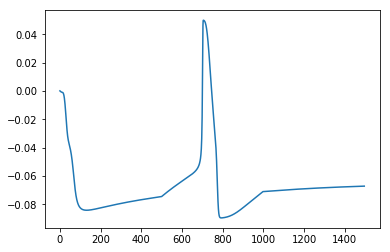

In [116]:
plt.plot(xx[7]);

In [117]:
Ntraces

2

## Calculate errors

#### RMS

In [118]:
rms_list

[0.01426619370927011,
 0.03197335190338737,
 0.03597595240112218,
 0.021402832375794663,
 0.023411445784563185,
 0.03257124949873216,
 0.028159824187310712,
 0.03189120221034984,
 0.02358793977459132,
 0.03227092482382402,
 0.015277418511517912,
 0.03310663887253646]

In [119]:
rms_len = len(rms_list)

In [120]:
rms_arr = np.reshape(np.array(rms_list), (int(rms_len/Ntraces), Ntraces))
rms_arr

array([[0.01426619, 0.03197335],
       [0.03597595, 0.02140283],
       [0.02341145, 0.03257125],
       [0.02815982, 0.0318912 ],
       [0.02358794, 0.03227092],
       [0.01527742, 0.03310664]])

In [121]:
err_out = rms_arr.mean(axis=1)
err_out

array([0.02311977, 0.02868939, 0.02799135, 0.03002551, 0.02792943,
       0.02419203])

#### MSE

In [122]:
mse_len = len(mse_list)
mse_len

12

In [123]:
mse_list

[0.30467585157677585,
 1.5303759622109534,
 1.9375209192982101,
 0.6857476068584273,
 0.8204994032041413,
 1.5881467819812645,
 1.1870846202955934,
 1.52252202129687,
 0.8329171815061915,
 1.5589946457103974,
 0.3493990760149771,
 1.6407861575425036]

In [124]:
mse_arr = np.reshape(np.array(mse_list), (int(mse_len/Ntraces), Ntraces))
mse_arr

array([[0.30467585, 1.53037596],
       [1.93752092, 0.68574761],
       [0.8204994 , 1.58814678],
       [1.18708462, 1.52252202],
       [0.83291718, 1.55899465],
       [0.34939908, 1.64078616]])

In [110]:
err_out_mse = mse_arr.mean(axis=1)
err_out_mse

array([0.00061291, 0.00087618, 0.00080449, 0.00090501, 0.0007989 ,
       0.00066472])

## Put it into function 

In [126]:
# ot

In [135]:
errors = []

for xx in ot:
    mse_list = []
    for row in xx:
        mse = np.sum(np.square(y - row))
        mse_list.append(mse)

    mse_len = len(mse_list)    
    mse_arr = np.reshape(np.array(mse_list), (int(mse_len/Ntraces), Ntraces))
    err_out_mse = mse_arr.mean(axis=1)
    errors.append(err_out_mse)
        
errors

[array([0.91752591, 1.31163426, 1.20432309, 1.35480332, 1.19595591,
        0.99509262]),
 array([1.13685345, 1.17426565, 0.90231299, 1.28277012, 1.18186926,
        1.18382946])]